Fitting data
======================================================================
This page shows you how to fit experimental data and plots the results
using matplotlib.

Adapted from https://github.com/scipy/scipy-cookbook/blob/master/ipython/FittingData.ipynb

<TableOfContents>

Fit examples with sinusoidal functions
--------------------------------------

### Generating the data

Using real data is much more fun, but, just so that you can reproduce
this example I will generate data to fit

In [8]:
import numpy as np
from numpy import pi, r_
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize

# Generate data points with noise
num_points = 150
Tx = np.linspace(5., 8., num_points)
Ty = Tx

tX = 11.86*np.cos(2*pi/0.81*Tx-1.32) + 0.64*Tx+4*((0.5-np.random.rand(num_points))*np.exp(2*np.random.rand(num_points)**2))
tY = -32.14*np.cos(2*np.pi/0.8*Ty-1.94) + 0.15*Ty+7*((0.5-np.random.rand(num_points))*np.exp(2*np.random.rand(num_points)**2))

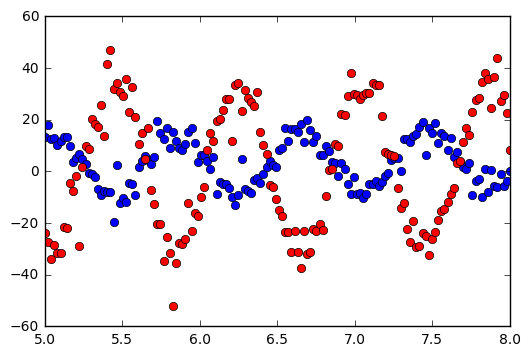

In [9]:
plt.plot(Tx, tX, 'bo',
         Ty, tY, 'ro')

### Fitting the data

We now have two sets of data: Tx and Ty, the time series, and tX and tY,
sinusoidal data with noise. We are interested in finding the frequency
of the sine wave.

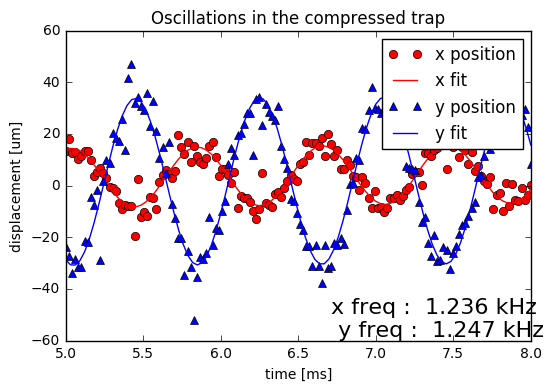

In [10]:
# Fit the first set
fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [-15., 0.8, 0., -1.] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))

time = np.linspace(Tx.min(), Tx.max(), 100)
plt.plot(Tx, tX, "ro", time, fitfunc(p1, time), "r-") # Plot of the data and the fit

# Fit the second set
p0 = [-15., 0.8, 0., -1.]
p2,success = optimize.leastsq(errfunc, p0[:], args=(Ty, tY))

time = np.linspace(Ty.min(), Ty.max(), 100)
plt.plot(Ty, tY, "b^", time, fitfunc(p2, time), "b-")

# Legend the plot
plt.title("Oscillations in the compressed trap")
plt.xlabel("time [ms]")
plt.ylabel("displacement [um]")
plt.legend(('x position', 'x fit', 'y position', 'y fit'))

ax = plt.axes()

plt.text(0.8, 0.07,
         'x freq :  %.3f kHz \n y freq :  %.3f kHz' % (1/p1[1],1/p2[1]),
         fontsize=16,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes)

plt.show()

### A clever use of the cost function

Suppose that you have the same data set: two time-series of oscillating
phenomena, but that you know that the frequency of the two oscillations
is the same. A clever use of the cost function can allow you to fit both
set of data in one fit, using the same frequency. The idea is that you
return, as a "cost" array, the concatenation of the costs of your two
data sets for one choice of parameters. Thus the leastsq routine is
optimizing both data sets at the same time.

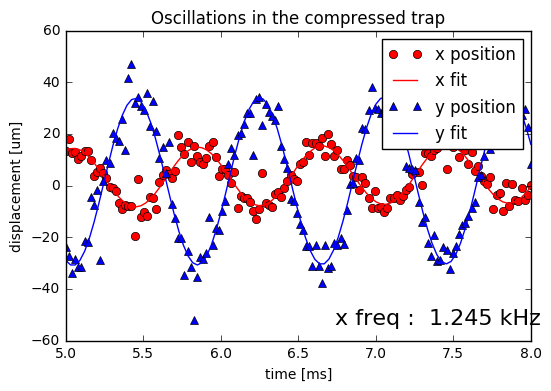

In [11]:
# Target function
fitfunc = lambda T, p, x: p[0]*np.cos(2*np.pi/T*x+p[1]) + p[2]*x
# Initial guess for the first set's parameters
p1 = r_[-15., 0., -1.]
# Initial guess for the second set's parameters
p2 = r_[-15., 0., -1.]
# Initial guess for the common period
T = 0.8
# Vector of the parameters to fit, it contains all the parameters of the problem, and the period of the oscillation is not there twice !
p = r_[T, p1, p2]
# Cost function of the fit, compare it to the previous example.
errfunc = lambda p, x1, y1, x2, y2: r_[
                fitfunc(p[0], p[1:4], x1) - y1,
                fitfunc(p[0], p[4:7], x2) - y2
            ]
# This time we need to pass the two sets of data, there are thus four "args".
p,success = optimize.leastsq(errfunc, p, args=(Tx, tX, Ty, tY))
time = np.linspace(Tx.min(), Tx.max(), 100) # Plot of the first data and the fit
plt.plot(Tx, tX, "ro", time, fitfunc(p[0], p[1:4], time),"r-")

# Plot of the second data and the fit
time = np.linspace(Ty.min(), Ty.max(),100)
plt.plot(Ty, tY, "b^", time, fitfunc(p[0], p[4:7], time),"b-")

# Legend the plot
plt.title("Oscillations in the compressed trap")
plt.xlabel("time [ms]")
plt.ylabel("displacement [um]")
plt.legend(('x position', 'x fit', 'y position', 'y fit'))

ax = plt.axes()

plt.text(0.8, 0.07,
         'x freq :  %.3f kHz' % (1/p[0]),
         fontsize=16,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes)

Simplifying the syntax
----------------------

Especially when using fits for interactive use, the standard syntax for
optimize.leastsq can get really long. Using the following script can
simplify your life:

In [29]:
import numpy as np
from scipy import optimize

class Parameter:
    def __init__(self, value):
            self.value = value

    def set(self, value):
            self.value = value
    
    #
    # This is where the magic is happening, the __call__ property is what determines what happens when we do param() below
    #
    def __call__(self):
            return self.value

def fit(function, parameters, y, x):
    def f(params):
        i = 0
        for p in parameters:
            p.set(params[i])
            i += 1
        return y - function(x)

    p = [param() for param in parameters]
    return optimize.leastsq(f, p)

Now fitting becomes really easy, for example fitting to a gaussian:

1.36078579749 0.997821132034 0.680220942117 0.0181697254758


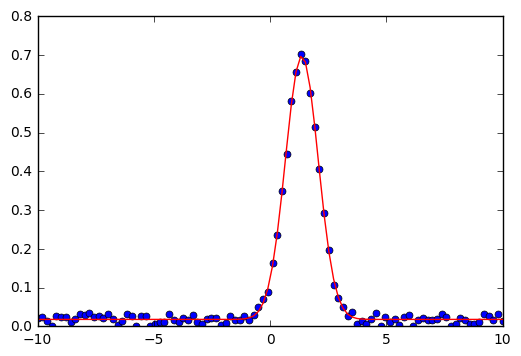

In [142]:
# giving initial parameters
mu = Parameter(0)                     
sigma = Parameter(3)
height = Parameter(5)
offset = Parameter(0)

# define your function:
def f(x): 
    return height() * np.exp(-((x-mu())/sigma())**2) + offset()

x = np.linspace(-10, 10, 100)
datacenter = 1 + 2*np.random.rand()
dataheight = 10*np.random.rand()
noiselevel = 0.05 * dataheight
# fit! (given that data is an array with the data to fit)
data = dataheight*np.exp(-(x-datacenter)**2) + noiselevel*np.random.rand(100)
[mu, sigma, height, offset], _ = fit(f, [mu, sigma, height, offset], data, x)
print mu, sigma, height, offset

plt.plot(x, data, 'bo', markersize=5)
# define your function:
def f(x): 
    return height * np.exp(-((x-mu)/sigma)**2) + offset
plt.plot(x, f(x), 'r-')

** Note: the search we're performing is not exhaustive, and it's very easy for `fit()` to get the wrong answer here if our initial guess is way off!  Try:  
`mu = Parameter(0), datacenter = 5, noiselevel = 0` **

Fitting gaussian-shaped data
----------------------------

### Calculating the moments of the distribution

Fitting gaussian-shaped data does not require an optimization routine.
Just calculating the moments of the distribution is enough, and this is
much faster.

However this works only if the gaussian is not cut out too much, and if
it is not too small.

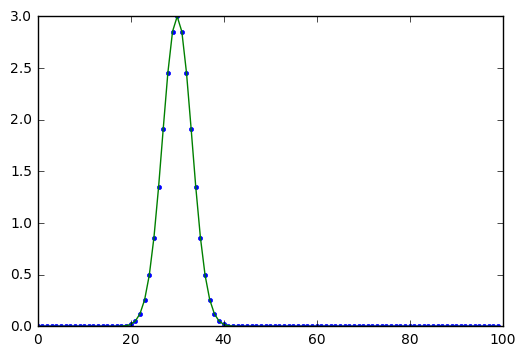

In [143]:
gaussian = lambda x: 3*np.exp(-(30-x)**2/20.)

data = gaussian(np.arange(100))

plt.plot(data, '.')

X = np.arange(data.size)
x = np.sum(X*data)/np.sum(data)
width = np.sqrt(np.abs(np.sum((X-x)**2*data)/np.sum(data)))

max = data.max()

fit = lambda t : max*np.exp(-(t-x)**2/(2*width**2))

plt.plot(fit(X), '-')

### Fitting a 2D gaussian

Here is robust code to fit a 2D gaussian. It calculates the moments of
the data to guess the initial parameters for an optimization routine.
For a more complete gaussian, one with an optional additive constant and
rotation, see
<http://code.google.com/p/agpy/source/browse/trunk/agpy/gaussfitter.py>.
It also allows the specification of a known error.

In [144]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

And here is an example using it:

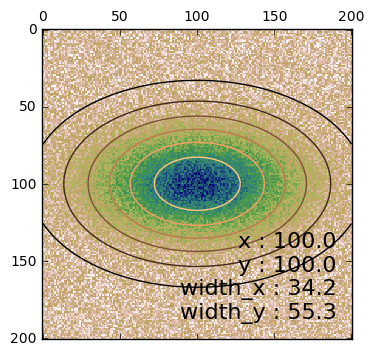

In [149]:
# Create the gaussian data
Xin, Yin = np.mgrid[0:201, 0:201]
data = gaussian(3, 100, 100, 20, 40)(Xin, Yin) + np.random.random(Xin.shape)

plt.matshow(data, cmap=plt.cm.gist_earth_r)

params = fitgaussian(data)
fit = gaussian(*params)

plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

Fitting a power-law to data with errors
---------------------------------------

### Generating the data

Generate some data with noise to demonstrate the fitting procedure. Data
is generated with an amplitude of 10 and a power-law index of -2.0.
Notice that all of our data is well-behaved when the log is taken... you
may have to be more careful of this for real data.

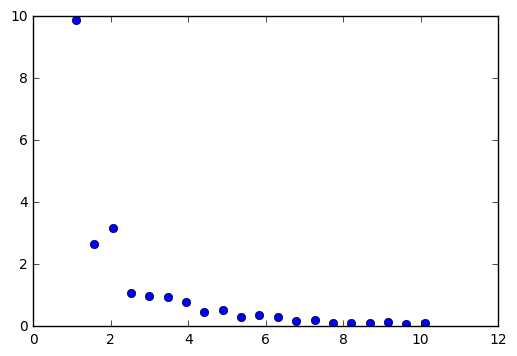

In [155]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

##########
# Generate data points with noise
##########
num_points = 20

# Note: all positive, non-zero data
xdata = np.linspace(1.1, 10.1, num_points) 
ydata = powerlaw(xdata, 10.0, -2.0)     # simulated perfect data
yerr = 0.2 * ydata                      # simulated errors (10%)

ydata += np.random.randn(num_points) * yerr       # simulated noisy data

plt.plot(xdata, ydata, 'bo')

### Fitting the data

If your data is well-behaved, you can fit a power-law function by first
converting to a linear equation by using the logarithm. Then use the
optimize function to fit a straight line. Notice that we are weighting
by positional uncertainties during the fit. Also, the best-fit
parameters uncertainties are estimated from the variance-covariance
matrix. You should read up on when it may not be appropriate to use this
form of error estimation. If you are trying to fit a power-law
distribution, [this
solution](http://code.google.com/p/agpy/wiki/PowerLaw?ts=1251337886&updated=PowerLaw)
is more appropriate.

[ 1.07245172 -2.07001006]
[[ 0.01369728 -0.01778332]
 [-0.01778332  0.02689263]]


(1.0, 11)

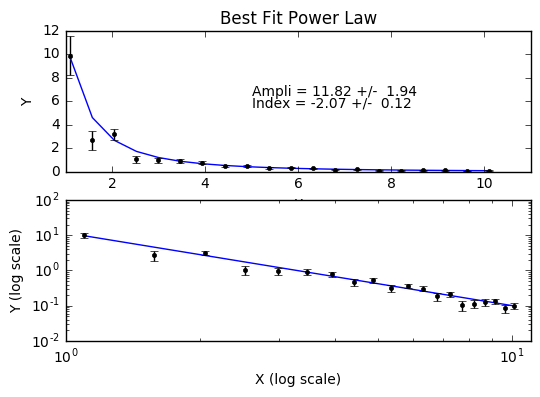

In [156]:
##########
# Fitting the data -- Least Squares Method
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x   
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print pfinal
print covar

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[0][0] ) 
ampErr = np.sqrt( covar[1][1] ) * amp

##########
# Plotting data
##########

plt.clf()
plt.subplot(2, 1, 1)
plt.plot(xdata, powerlaw(xdata, amp, index))     # Fit
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.text(5, 6.5, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
plt.text(5, 5.5, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
plt.title('Best Fit Power Law')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(1, 11)

plt.subplot(2, 1, 2)
plt.loglog(xdata, powerlaw(xdata, amp, index))
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
plt.xlim(1.0, 11)